In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import trange

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import concatenate, Dense, Input, Layer
from tensorflow.keras import Model

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc("figure", figsize=(12, 8))

In [3]:
def plot_observations(x, y, title, legend=False):
    plt.scatter(x, y, color="tab:blue", alpha=0.1)
    plt.xlim([-8, 8])
    plt.ylim([-30, 30])
    plt.title(title)
    if legend:
        plt.legend()

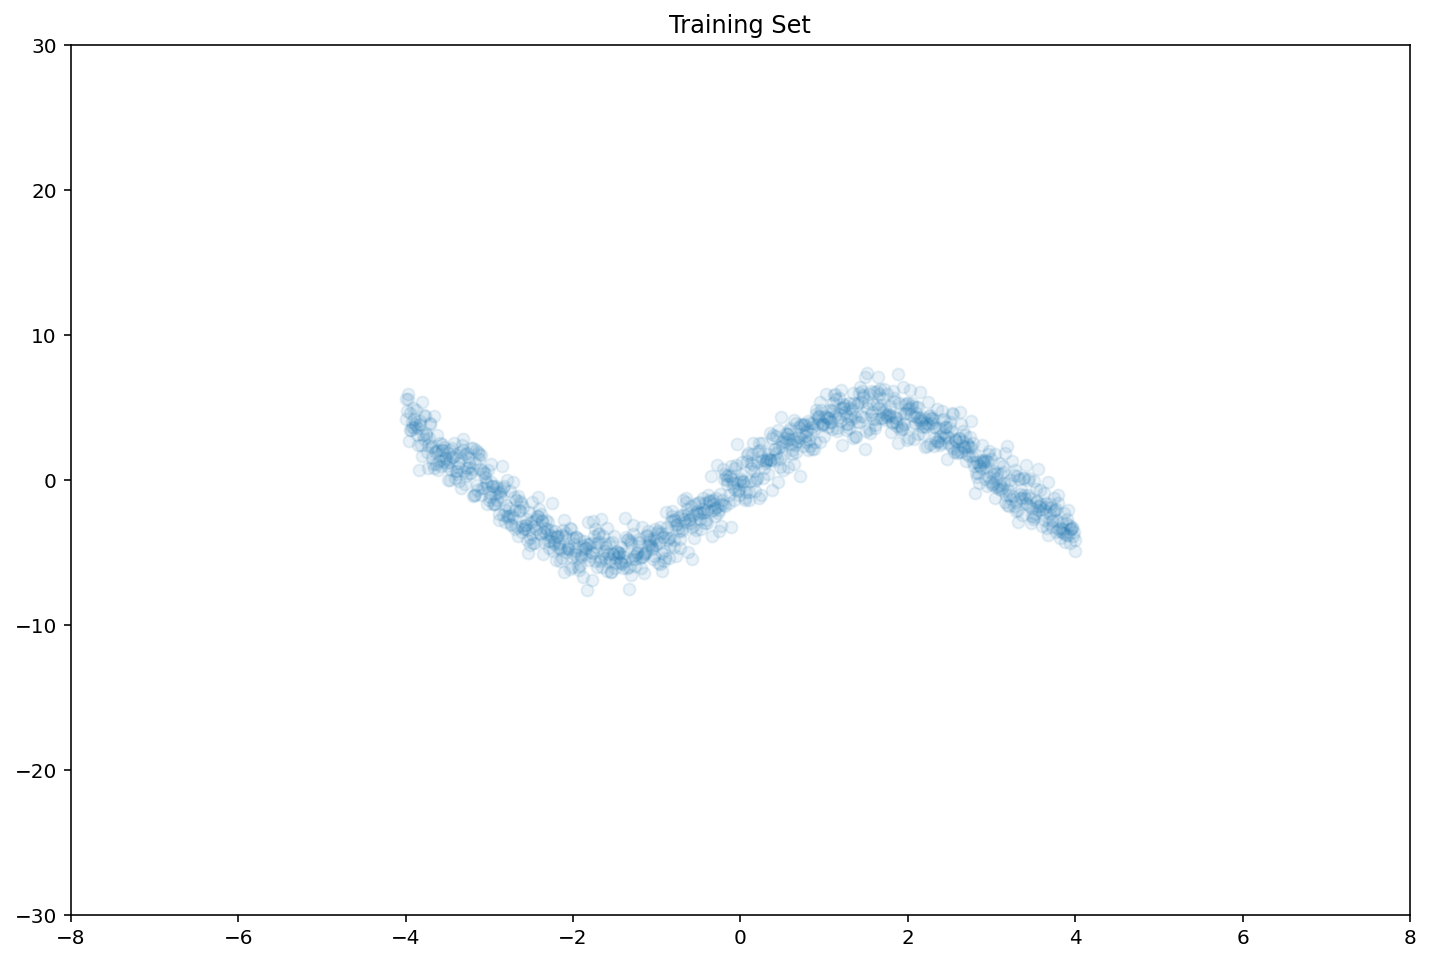

In [4]:
np.random.seed(0)
x_train = np.expand_dims(np.linspace(-4, 4, num=1000, dtype=np.float32), -1)
y_train = 5*(np.sin(x_train)) + np.random.normal(scale=1, size=x_train.shape)
plot_observations(x_train, y_train, title="Training Set")

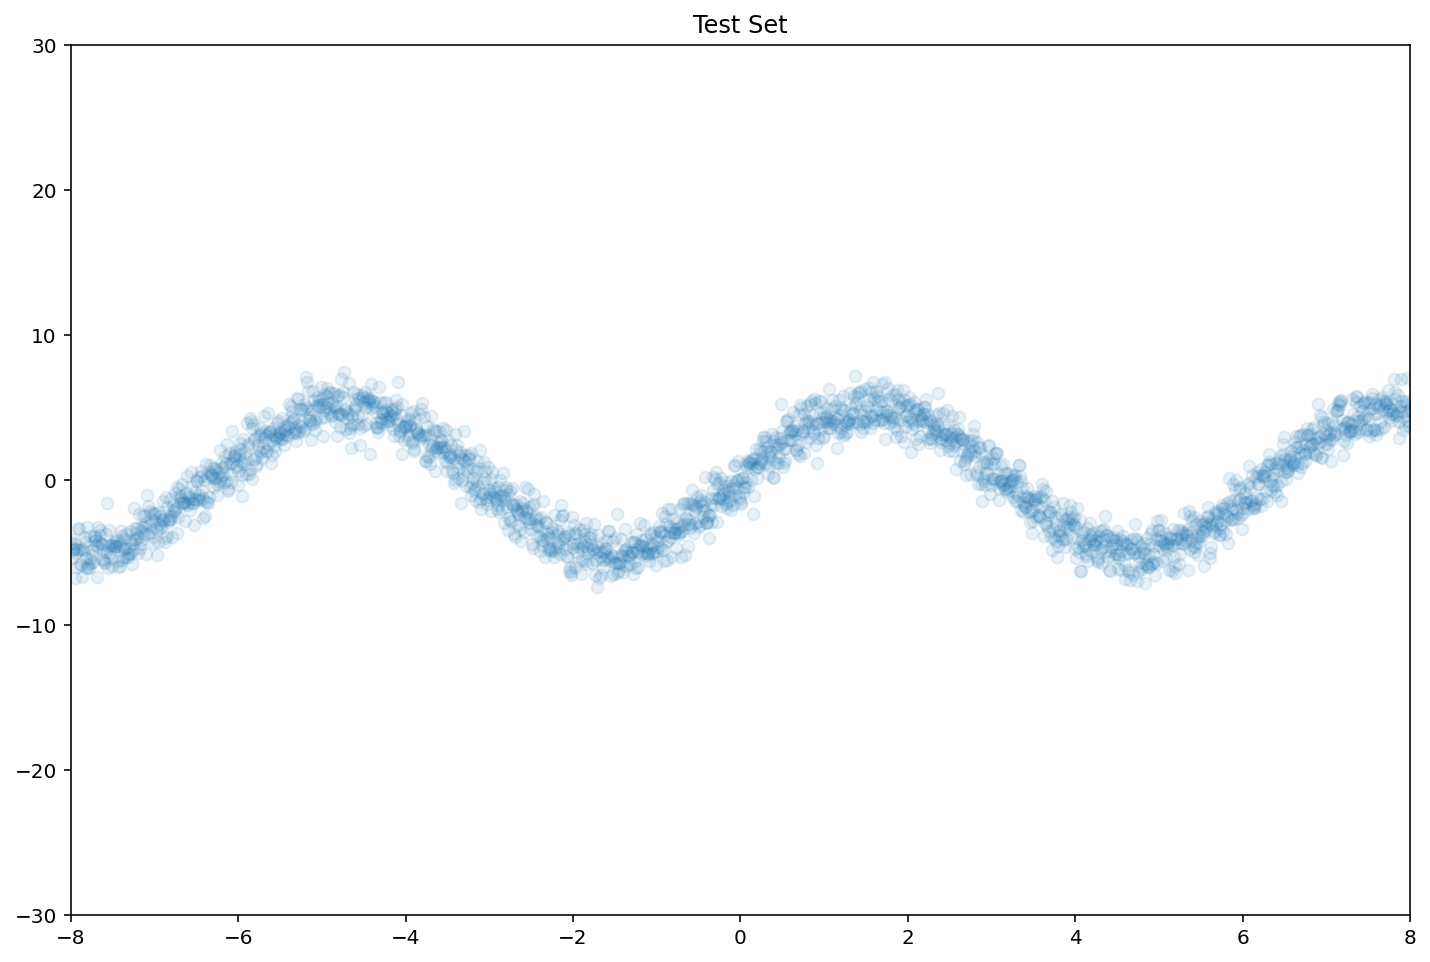

In [5]:
x_test = np.expand_dims(np.linspace(-8, 8, num=2000, dtype=np.float32), -1)
y_test = 5*(np.sin(x_test)) + np.random.normal(scale=1, size=x_test.shape)
plot_observations(x_test, y_test, title="Test Set")

In [6]:
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        
        self.dense1 = Dense(output_dim)
        self.dense2 = Dense(output_dim)
        
    def call(self, x):
        mu = self.dense1(x)
        raw_var = self.dense2(x)
        var = K.softplus(raw_var) + 1e-6
        outputs = concatenate([mu, var])
        return outputs
    

def gaussian_nll(y, x):
    mu, var = tf.split(x, 2, axis=1)
    return K.mean(0.5 * K.log(var) + 0.5 * (y - mu)**2 / var)

In [7]:
def create_gaussian_network(input_shape, output_shape):
    inputs = Input(input_shape)
    
    x = Dense(50, activation='relu')(inputs)
    x = Dense(50, activation='relu')(x)
    outputs = GaussianLayer(output_dim=output_shape[-1])(x)
    
    model = Model(inputs, outputs)
    return model

In [8]:
model = create_gaussian_network(input_shape=(1,), output_shape=(1,))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
gaussian_layer (GaussianLaye (None, 2)                 102       
Total params: 2,752
Trainable params: 2,752
Non-trainable params: 0
_________________________________________________________________


In [9]:
n_models = 5
n_test = x_test.shape[0]
mu, var = np.empty((n_models, n_test)), np.empty((n_models, n_test))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

for i in trange(n_models):
    model = create_gaussian_network(input_shape=(1,), output_shape=(1,))
    model.compile(loss=gaussian_nll, optimizer="adam")
    model.fit(x_train_scaled, y_train, epochs=100, verbose=0)
    mu[i], var[i] = model.predict(x_test_scaled).T

ensemble_mean = mu.mean(axis=0)
ensemble_variance = (var + mu**2 - ensemble_mean**2).mean(axis=0)
ensemble_stddev = np.sqrt(ensemble_variance)

100%|██████████| 5/5 [00:49<00:00,  9.82s/it]


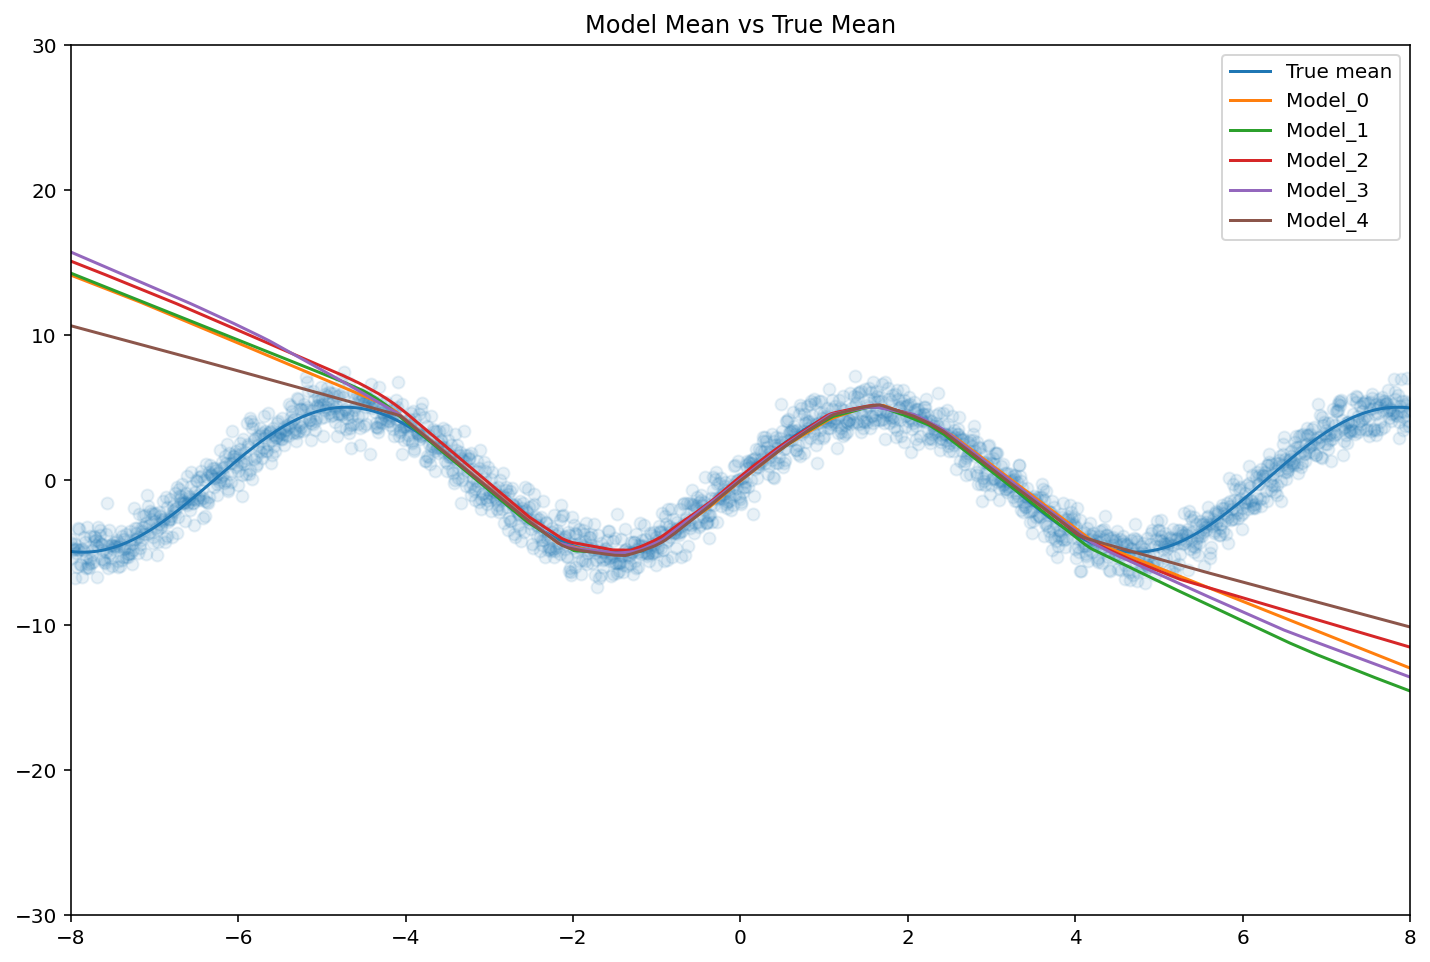

In [10]:
y_true = 5*(np.sin(x_test))
plt.plot(x_test, y_true, label="True mean")

for i in range(n_models):
    plt.plot(x_test, mu[i], label=f"Model_{i}")
    
plot_observations(x_test, y_test, title="Model Mean vs True Mean", legend=True)

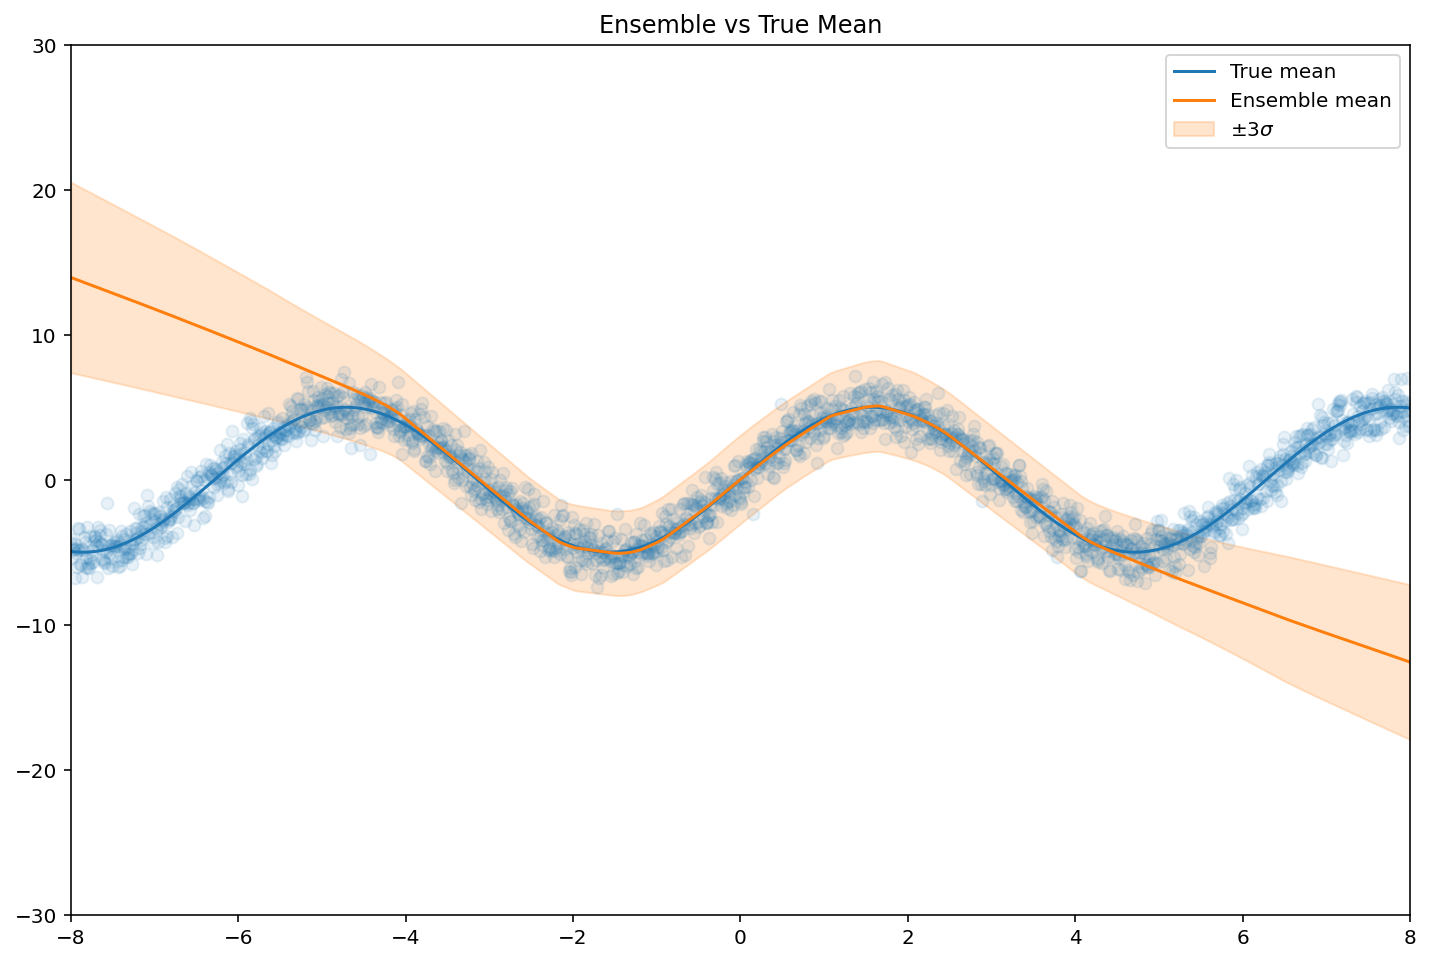

In [11]:
plt.plot(x_test, y_true, label="True mean")
plt.plot(x_test, ensemble_mean, label="Ensemble mean")
plt.fill_between(x_test.ravel(),
                 ensemble_mean - 3 * ensemble_stddev,
                 ensemble_mean + 3 * ensemble_stddev,
                 color="tab:orange",
                 alpha=0.2,
                 label="$\pm 3 \sigma$")
plot_observations(x_test, y_test, title="Ensemble vs True Mean", legend=True)